In [12]:
import numpy as np
import jax.numpy as jnp
import jax

from scipy.optimize import minimize
# from jax.scipy.optimize import minimize

import scoobpsf.jax_scoob as jscoob
import scoobpsf.jax_dm as jdm
from scoobpsf.imshows import *

from importlib import reload

Nact = 34
Nacts = 952
act_spacing = 300*u.um

pupil_diam = 10.2*u.mm
npix = 256

pupil_pxscl = pupil_diam/npix/u.pix

wavelength= 650*u.nm

from importlib import reload



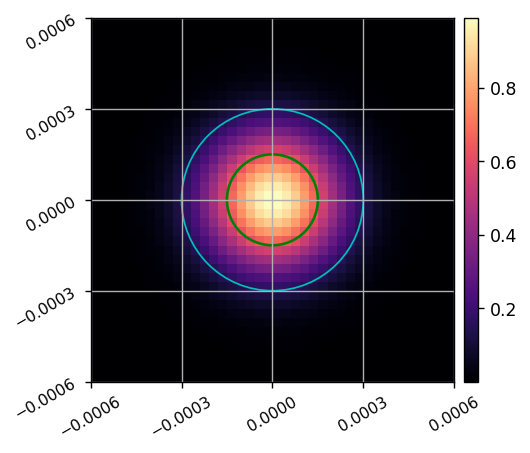

/home/kianmilani/miniconda3/envs/cpu311env/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


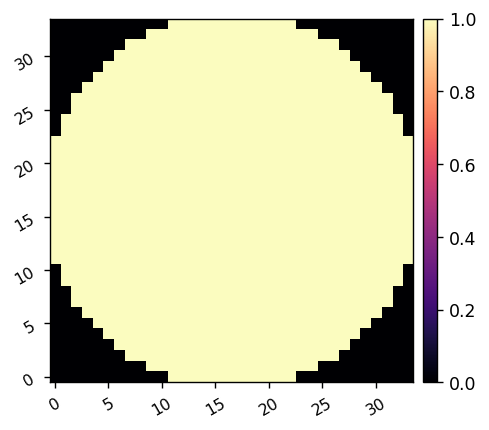

952


In [13]:
reload(jdm)
inf_fun, inf_sampling, inf_pixelscale = jdm.make_gaussian_inf_fun(sampling=10, Nacts_per_inf=4, plot=True)
inf_pixelscale = inf_pixelscale.to_value(u.m/u.pix)
dm_mask = jdm.make_dm_mask(plot=True)
print(dm_mask.sum())


Oversampling > 2x suggested for reliable results in Fresnel propagation.
Oversampling > 2x suggested for reliable results in Fresnel propagation.


Jax platform: cpu
Jax device: cpu


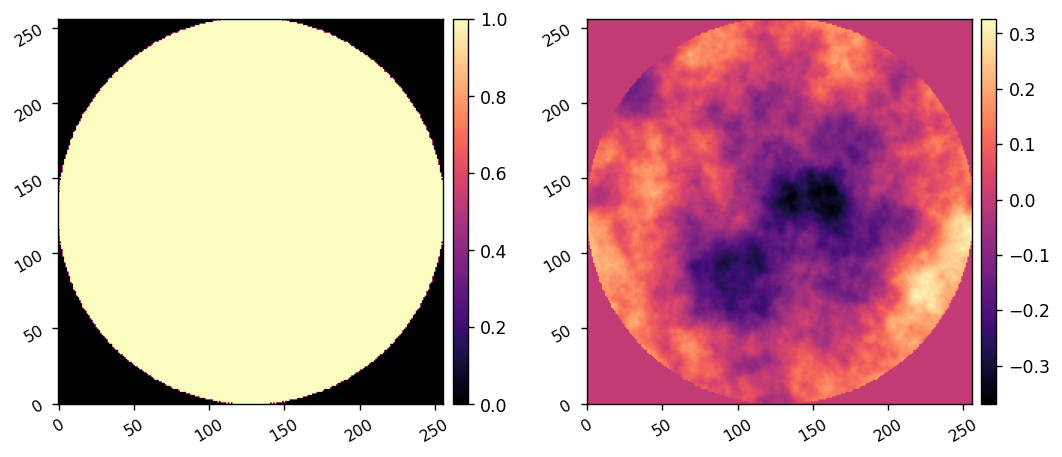

In [14]:
reload(jscoob)
oversample = 1
pupil = jscoob.make_pupil(pupil_diam, npix, oversample)>0

WFE = jscoob.generate_wfe(diam=pupil_diam,
                        #   amp_rms=0*u.nm, opd_rms=0*u.nm,
                          amp_rms=0.0, amp_index=3.2, opd_rms=10*u.nm, opd_index=3.5,
                          npix=npix, oversample=oversample,)

# WFE = lina.utils.generate_wfe(pupil_diam, wavelength=500*u.nm,
#                                 opd_index=2.8, amp_index=3.0, 
#                                 opd_seed=1234, amp_seed=12345,
#                                 opd_rms=17*u.nm, amp_rms=0.05,
#                                 npix=npix, oversample=oversample,
#                                 plot=True)

WFE = jnp.angle(WFE)
imshow2(pupil, WFE)




In [17]:
inf_pixelscale*u.m/u.pix

2.9999999999999997e-05

In [20]:
def cost_fun(del_actuators):
    '''
    acts: the actuator vector we want to find an optimal solution for
    I_tar_ratio: ratio for the desired target irradiance based on current integrated irradiance
    eta_00: parameter that Scott understands more
    E_ab: current electric-field estimate
    '''
    # delsurf = inf_matrix.dot(del_actuators).reshape(int(jnp.sqrt(inf_matrix.shape[0])), int(jnp.sqrt(inf_matrix.shape[0])))
    # delphi = 4*np.pi/wavelength.to_value(u.m) * jdm.interp_arr(delsurf, inf_pixelscale, pupil_pxscl)    
    # delphi = jdm.pad_or_crop(delphi, npix)

    command = jdm.map_actuators_to_command(del_actuators, dm_mask)
    delphi = jnp.angle(jdm.get_phasor(command, inf_fun, inf_sampling, inf_pixelscale=inf_pixelscale*u.m/u.pix, pixelscale=pupil_pxscl))
    delphi = jdm.pad_or_crop(delphi, npix)
    
    total = WFE[pupil] + delphi[pupil]
    J = total.dot(total)/822.08109784

    return J

In [21]:
del_actuators = jnp.zeros(Nacts)
cost_fun(del_actuators)

Array(0.98551441, dtype=float64)

/home/kianmilani/miniconda3/envs/cpu311env/lib/python3.11/site-packages/jax/_src/lax/lax.py:2638: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


0.9855144109344819 (952,)


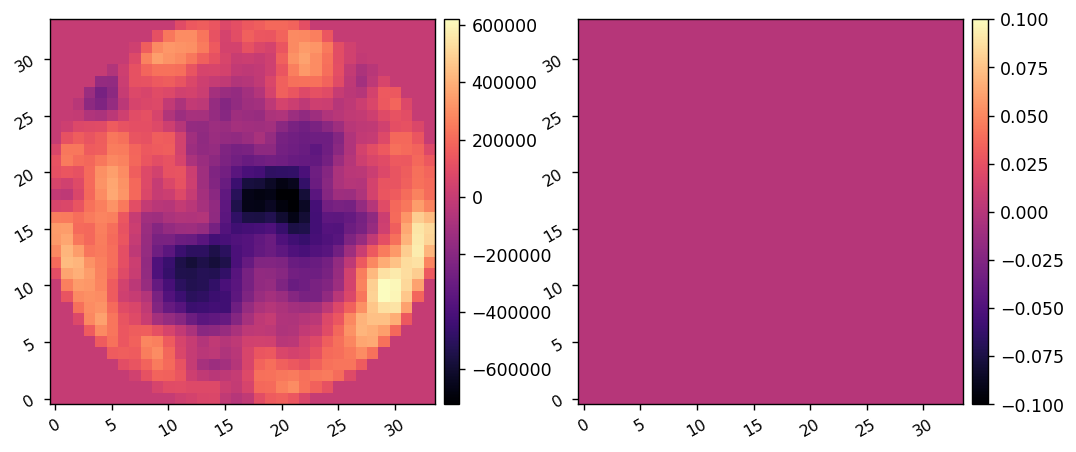

In [22]:
del_actuators = jnp.zeros(Nacts)
# del_actuators = jnp.array(np.random.randn(Nacts))*0.5e-9
command = jdm.map_actuators_to_command(del_actuators, dm_mask)
value_and_grad_of_cost = jax.value_and_grad(cost_fun)

val_and_grad = value_and_grad_of_cost(del_actuators)
print(val_and_grad[0], val_and_grad[1].shape)
grad_command = jdm.map_actuators_to_command(val_and_grad[1], dm_mask)
imshow2(grad_command/2, command)

In [23]:
del_acts0 = jnp.zeros(Nacts)

In [24]:
from scipy.optimize import minimize
res = minimize(value_and_grad_of_cost, jac=True, x0=del_acts0, 
                method='L-BFGS-B', 
                tol=1e-5,
                options={'disp':True},
                )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85514D-01    |proj g|=  1.44565D+06


 This problem is unconstrained.



At iterate    1    f=  2.37762D-01    |proj g|=  6.69020D+05

At iterate    2    f=  2.21986D-02    |proj g|=  1.02173D+05

At iterate    3    f=  1.78396D-02    |proj g|=  7.24393D+04

At iterate    4    f=  1.31954D-02    |proj g|=  2.64559D+04

At iterate    5    f=  1.24969D-02    |proj g|=  3.24451D+04

At iterate    6    f=  1.20878D-02    |proj g|=  1.38195D+04

At iterate    7    f=  1.19224D-02    |proj g|=  1.37391D+04

At iterate    8    f=  1.17868D-02    |proj g|=  1.15892D+04

At iterate    9    f=  1.17066D-02    |proj g|=  9.38546D+03

At iterate   10    f=  1.16440D-02    |proj g|=  5.81050D+03

At iterate   11    f=  1.16212D-02    |proj g|=  4.67539D+03

At iterate   12    f=  1.15993D-02    |proj g|=  3.54360D+03

At iterate   13    f=  1.15956D-02    |proj g|=  8.30010D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

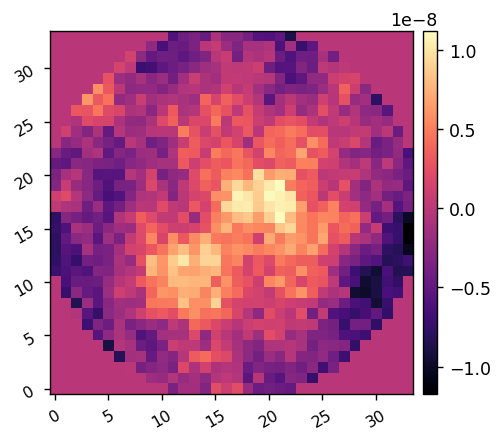

In [25]:
acts = res.x
command = jdm.map_actuators_to_command(res.x, dm_mask)
imshow1(command)


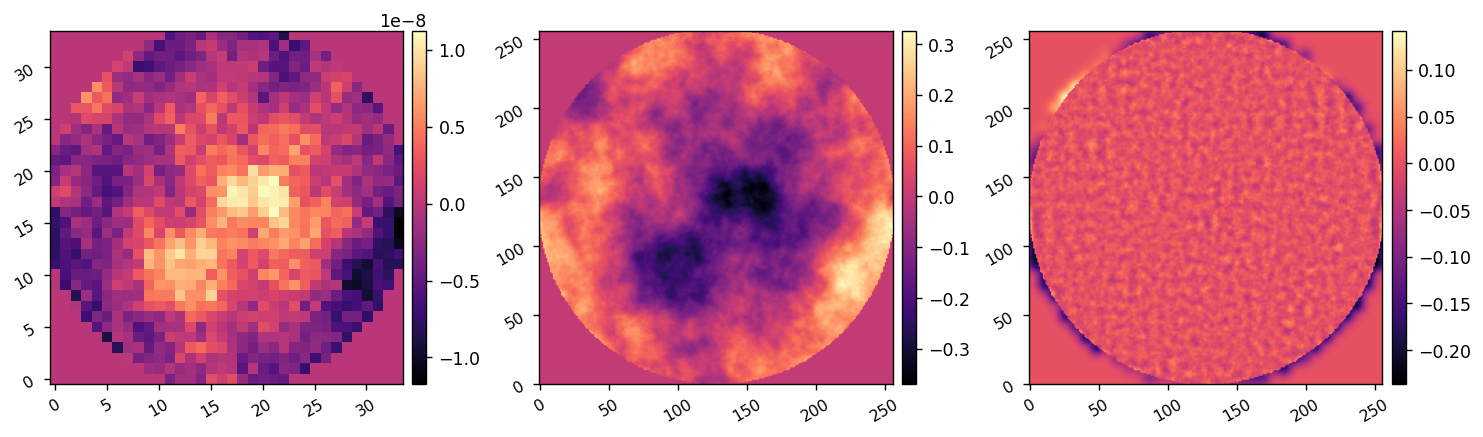

In [27]:
acts = res.x
command = jdm.map_actuators_to_command(res.x, dm_mask)

# delsurf = inf_matrix.dot(acts).reshape(int(jnp.sqrt(inf_matrix.shape[0])), int(jnp.sqrt(inf_matrix.shape[0])))
# delphi = 4*np.pi/wavelength.to_value(u.m) * jdm.interp_arr(delsurf, inf_pixelscale, pupil_pxscl)
# delphi = jdm.pad_or_crop(delphi, npix)

delphi = jnp.angle(jdm.get_phasor(command, inf_fun, inf_sampling, inf_pixelscale=inf_pixelscale*u.m/u.pix, pixelscale=pupil_pxscl))
delphi = jdm.pad_or_crop(delphi, npix)

total = WFE + delphi
imshow3(command, WFE, total)